# Kaggle Competition: Loan Payment Prediction

###  Problem Statement: Produce a supervised machine learning model to predict whether a loan will be paid in full or charged off

## Step One: Data processing and cleaning

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
import datetime as dt

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

Packages for model build:

In [2]:
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc

Load the data to Pandas:

In [3]:
df=pd.read_csv('CaseStudy_Dataset.csv')

C:\Users\kangd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(42545, 144)

Check the column information:

In [6]:
list(df.columns)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

Check the target variable - loan_status by using value_counts():

In [7]:
df['loan_status'].value_counts()

Fully Paid                                             34121
Charged Off                                             5672
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

Usually for loan applications which **didn't meet credit policy**, they should be declined directly before sent to the model.
Although, in this case these loans still had 'Status' information, we **would remove these records from build model and assume these loans won't be processed by the model** 

Only keep records which passed credit policy:

In [8]:
df=df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [9]:
df['loan_status'].value_counts()

Fully Paid     34121
Charged Off     5672
Name: loan_status, dtype: int64

Define a function to check missing values:

In [10]:
def missing_values_table(df):
        #1 Total missing values
        mis_val = df.isnull().sum()
        
        #2 Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #3 Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #4 Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        #5 Only keep the columns with missing values
        mis_val_table_only = mis_val_table_ren_columns.loc[mis_val_table_ren_columns['% of Total Values'] > 0]
        
        #6 Return the dataframe with missing information
        return mis_val_table_only

In [11]:
missing_values_table(df)

,Missing Values,% of Total Values
id,39793,100.000000
member_id,39793,100.000000
emp_title,2468,6.202096
emp_length,1078,2.709019
url,39793,100.000000
...,...,...
settlement_status,39643,99.623049
settlement_date,39643,99.623049
settlement_amount,39643,99.623049
settlement_percentage,39643,99.623049


Practice:

Let's break down this function into small pieces and run each step
one by one to better understand it

In [12]:
#Step one: Total missing values
mis_val = df.isnull().sum()
mis_val

id                       39793
member_id                39793
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_status        39643
settlement_date          39643
settlement_amount        39643
settlement_percentage    39643
settlement_term          39643
Length: 144, dtype: int64

In [13]:
#Step two: Percentage of missing values
mis_val_percent = 100 * df.isnull().sum() / len(df)
mis_val_percent

id                       100.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_status         99.623049
settlement_date           99.623049
settlement_amount         99.623049
settlement_percentage     99.623049
settlement_term           99.623049
Length: 144, dtype: float64

In [14]:
#Step three: Make a table with the results
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
mis_val_table

,0,1
id,39793,100.000000
member_id,39793,100.000000
loan_amnt,0,0.000000
funded_amnt,0,0.000000
funded_amnt_inv,0,0.000000
...,...,...
settlement_status,39643,99.623049
settlement_date,39643,99.623049
settlement_amount,39643,99.623049
settlement_percentage,39643,99.623049


  - pandas.concat()将DataFrame中的数据按照列或者行的方向连接起来：
    - axis参数：默认为0。1代表按照列的方向(左右接/横向)，0代表按照行的方向(上下接/纵向)

In [15]:
pd.concat([mis_val, mis_val_percent]).head(100)

id                     39793.0
member_id              39793.0
loan_amnt                  0.0
funded_amnt                0.0
funded_amnt_inv            0.0
                        ...   
num_op_rev_tl          39793.0
num_rev_accts          39793.0
num_rev_tl_bal_gt_0    39793.0
num_sats               39793.0
num_tl_120dpd_2m       39793.0
Length: 100, dtype: float64

In [16]:
#Step four: Rename the columns
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns

,Missing Values,% of Total Values
id,39793,100.000000
member_id,39793,100.000000
loan_amnt,0,0.000000
funded_amnt,0,0.000000
funded_amnt_inv,0,0.000000
...,...,...
settlement_status,39643,99.623049
settlement_date,39643,99.623049
settlement_amount,39643,99.623049
settlement_percentage,39643,99.623049


In [17]:
#Step Five: Only keep the columns with missing rate > 0
mis_val_table_only = mis_val_table_ren_columns.loc[mis_val_table_ren_columns['% of Total Values'] > 0]
mis_val_table_only

,Missing Values,% of Total Values
id,39793,100.000000
member_id,39793,100.000000
emp_title,2468,6.202096
emp_length,1078,2.709019
url,39793,100.000000
...,...,...
settlement_status,39643,99.623049
settlement_date,39643,99.623049
settlement_amount,39643,99.623049
settlement_percentage,39643,99.623049


Apply the function to our dataframe:

In [18]:
missing=missing_values_table(df)
missing

,Missing Values,% of Total Values
id,39793,100.000000
member_id,39793,100.000000
emp_title,2468,6.202096
emp_length,1078,2.709019
url,39793,100.000000
...,...,...
settlement_status,39643,99.623049
settlement_date,39643,99.623049
settlement_amount,39643,99.623049
settlement_percentage,39643,99.623049


Usually there are three options to deal with missing values:
 1. Imputation
 2. Create missing flag
 3. Drop columns with a high percentage of missing vlaues

We see there are a number of columns with a high percentage of missing values. 
There is no well-established threshold for removing missing values, 

and the best course of action depends on the problem. 

Here, to reduce the number of features, we will remove any columns that have greater than 80% missing rate (in real situations, the threshold can be 98%).

In [19]:
# find columns with missing > 80%
missing_columns = list(missing.index[missing['% of Total Values'] > 80])
missing_columns

['id',
 'member_id',
 'url',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m

Drop these columns with missing rate > 80%:

In [20]:
df2 = df.drop(columns = missing_columns)
missing_values_table(df2)

,Missing Values,% of Total Values
emp_title,2468,6.202096
emp_length,1078,2.709019
desc,12969,32.591159
title,11,0.027643
mths_since_last_delinq,25733,64.667153
revol_util,50,0.125650
last_pymnt_d,71,0.178423
last_credit_pull_d,2,0.005026
collections_12_mths_ex_med,56,0.140728
chargeoff_within_12_mths,56,0.140728


Check duplicates in Pandas:

In [21]:
# DataFrame.duplicated(): Return boolean Series denoting duplicate rows
df2.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
39788    False
39789    False
39790    False
39791    False
39792    False
Length: 39793, dtype: bool

In [22]:
df2.loc[df2.duplicated()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag
10,3000.0,3000.0,3000.000000,36 months,18.64%,109.43,E,E1,MKC Accounting,9 years,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
11,5600.0,5600.0,5600.000000,60 months,21.28%,152.39,F,F2,NaN,4 years,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
24670,10000.0,10000.0,9932.403848,36 months,7.51%,311.11,A,A4,ResMed,< 1 year,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
24671,8400.0,8400.0,8350.000000,36 months,7.51%,261.34,A,A4,Defense Language Institute,4 years,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
24672,7200.0,4525.0,4522.491529,60 months,6.17%,87.84,A,A3,MARR Inc.,2 years,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
24673,12000.0,12000.0,12000.000000,36 months,11.86%,397.77,B,B5,Gaming Laboratories International,3 years,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
24674,15000.0,9875.0,9625.000000,60 months,15.95%,239.88,E,E1,Hospital for Special Surgery,2 years,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N


Remove duplicates:

In [23]:
# DataFrame.drop_duplicates(): Return DataFrame with duplicate rows removed
  # inplace (bool, default False): Whether to drop duplicates in place or to return a copy
df2.drop_duplicates(inplace= True)
df2.shape

(39786, 54)

## Step Two: Exploratory Data Analysis

###### 2.1 Check whether the data is balanced or imbalanced

Practice:
1. Encode the target variable as 1 for 'Charged Off' and 0 for 'Fully Paid':
2. Calculate the charge off rate:

In [24]:
df2['target'] = df2['loan_status'].apply(lambda x:1 if x == 'Charged Off' else 0)

In [25]:
df2.target.sum() / df2.shape[0] * 100

14.251244156235861

The data is imbalanced

##### 2.2 Drop Columns May Cause Data Leakge

In [26]:
data_leakage_cols = ['funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
                     'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
                     'last_pymnt_amnt','chargeoff_within_12_mths','debt_settlement_flag']

In [27]:
df2.drop(columns=data_leakage_cols, inplace=True)

##### 2.3 Explore numerical features

Basic descriptive statistics view:

In [28]:
df2.describe()

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,collections_12_mths_ex_med,policy_code,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,target
count,39786.000000,39786.000000,3.978600e+04,39786.000000,39786.000000,39786.000000,14059.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.0,39786.0,39730.0,39786.0,39786.0,39786.0,39089.000000,39747.0,39786.000000
mean,11231.360277,324.733637,6.897907e+04,13.317794,0.146534,0.869049,35.901913,9.294023,0.055145,13391.983914,22.090308,0.0,0.0,0.0,1.0,0.0,0.0,0.043286,0.0,0.142512
std,7464.542832,208.923212,6.376263e+04,6.678300,0.491826,1.070069,22.017895,4.399997,0.237653,15894.635107,11.401620,0.0,0.0,0.0,0.0,0.0,0.0,0.204381,0.0,0.349579
min,500.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
25%,5500.000000,167.080000,4.050000e+04,8.180000,0.000000,0.000000,18.000000,6.000000,0.000000,3704.250000,13.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
50%,10000.000000,280.610000,5.900000e+04,13.410000,0.000000,1.000000,34.000000,9.000000,0.000000,8859.500000,20.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
75%,15000.000000,430.780000,8.234250e+04,18.600000,0.000000,1.000000,52.000000,12.000000,0.000000,17065.000000,29.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
max,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,90.000000,0.0,0.0,0.0,1.0,0.0,0.0,2.000000,0.0,1.000000


In [29]:
df2['delinq_amnt'].value_counts()

0.0    39786
Name: delinq_amnt, dtype: int64

Drop columns with constant values:
- collections_12_mths_ex_med
- tax_liens
- out_prncp
- out_prncp_inv
- delinq_amnt
- acc_now_delinq 

In [30]:
df2.drop(columns=['collections_12_mths_ex_med','tax_liens','out_prncp','out_prncp_inv','delinq_amnt','acc_now_delinq'], inplace=True)

In [31]:
df2.shape

(39786, 37)

##### 2.5 Explore Categorical features

In [32]:
print(df2.info(0))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39786 entries, 0 to 39792
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               39786 non-null  float64
 1   term                    39786 non-null  object 
 2   int_rate                39786 non-null  object 
 3   installment             39786 non-null  float64
 4   grade                   39786 non-null  object 
 5   sub_grade               39786 non-null  object 
 6   emp_title               37319 non-null  object 
 7   emp_length              38708 non-null  object 
 8   home_ownership          39786 non-null  object 
 9   annual_inc              39786 non-null  float64
 10  verification_status     39786 non-null  object 
 11  issue_d                 39786 non-null  object 
 12  loan_status             39786 non-null  object 
 13  pymnt_plan              39786 non-null  object 
 14  desc                    26819 non-null

Create a separate DataFrame consisting of only categorical features:

In [33]:
df_cat=df2.select_dtypes(include=['object'])
df_cat.head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,...,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,11-Dec,Fully Paid,...,Computer,860xx,AZ,Jan-85,83.70%,f,15-Jan,19-May,Individual,N
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,11-Dec,Charged Off,...,bike,309xx,GA,Apr-99,9.40%,f,13-Apr,16-Oct,Individual,N
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,11-Dec,Fully Paid,...,real estate business,606xx,IL,1-Nov,98.50%,f,14-Jun,17-Jun,Individual,N
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,11-Dec,Fully Paid,...,personel,917xx,CA,Feb-96,21%,f,15-Jan,16-Apr,Individual,N
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,11-Dec,Fully Paid,...,Personal,972xx,OR,Jan-96,53.90%,f,17-Jan,18-Apr,Individual,N


Drop the target column and create a list with all categorical columns:

In [34]:
cat_columns=list(df_cat.drop(columns=['loan_status']).columns)
cat_columns

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag']

Strip leading and trailing space of each categorical column:

In [35]:
for i in cat_columns:   
    df2[i] = df2[i].str.strip()

Quickly explore each each categorical feature and check the frequency:

In [36]:
pd.set_option('display.max_columns', None)
df2[cat_columns].head(5)

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,11-Dec,n,Borrower added on 12/22/11 > I need to upgrade...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,f,15-Jan,19-May,Individual,N
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,11-Dec,n,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,Apr-99,9.40%,f,13-Apr,16-Oct,Individual,N
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,11-Dec,n,NaN,small_business,real estate business,606xx,IL,1-Nov,98.50%,f,14-Jun,17-Jun,Individual,N
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,11-Dec,n,Borrower added on 12/21/11 > to pay for proper...,other,personel,917xx,CA,Feb-96,21%,f,15-Jan,16-Apr,Individual,N
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,11-Dec,n,Borrower added on 12/21/11 > I plan on combini...,other,Personal,972xx,OR,Jan-96,53.90%,f,17-Jan,18-Apr,Individual,N


Check frequency:

In [37]:
for i in cat_columns:
    print(df2[i].value_counts().to_frame())

            term
36 months  29096
60 months  10690
        int_rate
10.99%       958
13.49%       831
11.49%       826
7.51%        787
7.88%        725
...          ...
16.01%         1
17.44%         1
14.67%         1
24.59%         1
21.48%         1

[371 rows x 1 columns]
   grade
B  12035
A  10085
C   8111
D   5325
E   2858
F   1054
G    318
    sub_grade
B3       2924
A4       2886
A5       2742
B5       2709
B4       2514
..        ...
G1        105
G2         78
G4         56
G3         49
G5         30

[35 rows x 1 columns]
                               emp_title
US Army                              136
Bank of America                      109
IBM                                   67
AT&T                                  64
Kaiser Permanente                     57
...                                  ...
Price Rite Supermarkets                1
Deutsche Bank Securities Inc.          1
united  airlines                       1
Pacificorp                             1
Spectru

In [38]:
df2['emp_title'].value_counts()

US Army                          136
Bank of America                  109
IBM                               67
AT&T                              64
Kaiser Permanente                 57
                                ... 
Price Rite Supermarkets            1
Deutsche Bank Securities Inc.      1
united  airlines                   1
Pacificorp                         1
Spectrum Health Medical Group      1
Name: emp_title, Length: 28658, dtype: int64

In [39]:
df2['title'].value_counts()

Debt Consolidation                         2262
Debt Consolidation Loan                    1745
Personal Loan                               678
Consolidation                               534
debt consolidation                          530
                                           ... 
Mike                                          1
Sure Thing                                    1
2010 Consol Cr1                               1
Technical Professional Credit Card Refi       1
Out of Debt 2014                              1
Name: title, Length: 19353, dtype: int64

In [40]:
df2['application_type'].value_counts()

Individual    39786
Name: application_type, dtype: int64

In [41]:
df2['desc'].value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      210
Debt Consolidation                                                                                                                                                                                                                                                                                                                                                                                            

After the exploratory analysis, we have a few findings:

1. **'desc'** is not relevant to the mdoel build and should be dropped

2. Drop all **date columns** to simplify the model build in this case. If we have more time, we can do some feature engineering by using date features, e.g. df_loan['issue_to_earliest_cr_line'] = df_loan['issue_d'] - df_loan['earliest_cr_line']

3. **'pmnt_plan','hardship_flag','initial_list_status' and 'application_type'** only have constant values and are useless for model build

4. **'emp_title', 'zip_code', and 'title'** have too many unique values and are not informative, we should drop them 

5. To simplify the analysis, we only **keep 'grade' and drop 'sub_grade'**

6. Also, some types of information filled in by customer are very difficult to verify (customers can put whatever they want to). To simplify the analysis for this case, we should drop these columns that cann't be easily verified: **'emp_length', 'purpose'**

Finally, we create a list including all categorical columns should be dropped

In [42]:
drop_feature=['desc','issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line', 'pymnt_plan','hardship_flag', 'emp_title',
             'emp_length', 'zip_code','title', 'purpose','sub_grade','initial_list_status','application_type']

In [43]:
# Drop thoes features
df2 = df2.drop(columns=drop_feature)

In [44]:
df2.head(5)

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,pub_rec_bankruptcies,target
0,5000.0,36 months,10.65%,162.87,B,RENT,24000.0,Verified,Fully Paid,AZ,27.65,0.0,1.0,NaN,3.0,0.0,13648.0,83.70%,9.0,1.0,0.0,0
1,2500.0,60 months,15.27%,59.83,C,RENT,30000.0,Source Verified,Charged Off,GA,1.00,0.0,5.0,NaN,3.0,0.0,1687.0,9.40%,4.0,1.0,0.0,1
2,2400.0,36 months,15.96%,84.33,C,RENT,12252.0,Not Verified,Fully Paid,IL,8.72,0.0,2.0,NaN,2.0,0.0,2956.0,98.50%,10.0,1.0,0.0,0
3,10000.0,36 months,13.49%,339.31,C,RENT,49200.0,Source Verified,Fully Paid,CA,20.00,0.0,1.0,35.0,10.0,0.0,5598.0,21%,37.0,1.0,0.0,0
4,3000.0,60 months,12.69%,67.79,B,RENT,80000.0,Source Verified,Fully Paid,OR,17.94,0.0,0.0,38.0,15.0,0.0,27783.0,53.90%,38.0,1.0,0.0,0


In [45]:
remaining_cat_fea=[i for i in cat_columns if i not in drop_feature]
remaining_cat_fea

['term',
 'int_rate',
 'grade',
 'home_ownership',
 'verification_status',
 'addr_state',
 'revol_util']

##### 2.6 Encode remaining categorical features

Convert 'revol_util' into a numerical feature:

In [46]:
df2['revol_util'].value_counts()

0%        980
0.20%      63
63%        62
40.70%     59
66.70%     58
         ... 
0.86%       1
10.17%      1
17.67%      1
21.92%      1
57.56%      1
Name: revol_util, Length: 1089, dtype: int64

In [47]:
df2['revol_util'] = df2['revol_util'].str.replace('%', '').astype(float)/100
df2['revol_util'].value_counts()

0.0000    980
0.0020     63
0.6300     62
0.4070     59
0.6670     58
         ... 
0.2781      1
0.0001      1
0.2311      1
0.1778      1
0.3489      1
Name: revol_util, Length: 1089, dtype: int64

Practice:

1. Convert 'int_rate' into a numerical feature:
2. Convert 'verification_status' into a numerical feature: if 'Not Verified' then 0, else 1

In [48]:
df2['int_rate'].value_counts()

10.99%    958
13.49%    831
11.49%    826
7.51%     787
7.88%     725
         ... 
16.01%      1
17.44%      1
14.67%      1
24.59%      1
21.48%      1
Name: int_rate, Length: 371, dtype: int64

In [49]:
df2['int_rate'] = df2['int_rate'].str.replace('%', '').astype(float)/100
df2['int_rate'].value_counts()

0.1099    958
0.1349    831
0.1149    826
0.0751    787
0.0788    725
         ... 
0.1836      1
0.1671      1
0.1872      1
0.2440      1
0.2264      1
Name: int_rate, Length: 371, dtype: int64

In [50]:
df2['verification_status'].value_counts()

Not Verified       16926
Verified           12844
Source Verified    10016
Name: verification_status, dtype: int64

In [51]:
df2['verification_status'] = df2['verification_status'].apply(lambda x: 0 if x == 'Not Verified' else 1)
df2['verification_status'].value_counts()

1    22860
0    16926
Name: verification_status, dtype: int64

Check remaining categorical features:

In [52]:
list(df2.select_dtypes(include=['object']).columns)

['term', 'grade', 'home_ownership', 'loan_status', 'addr_state']

Remove 'loan_status':

In [53]:
df2=df2.drop(columns=['loan_status'])

##### 2.7 One-hot encoding for remaining categorical features:

Most machine learning models unfortunately cannot deal with categorical variables

There are two mains to encode categorical variables:

1. **Label encoding**: assign each unique category 
   in a categorical variable with an integer. 
   
   No new columns are created.

2. **One-hot encoding**: create a new column for each unique category in a categorical variable. 

    Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

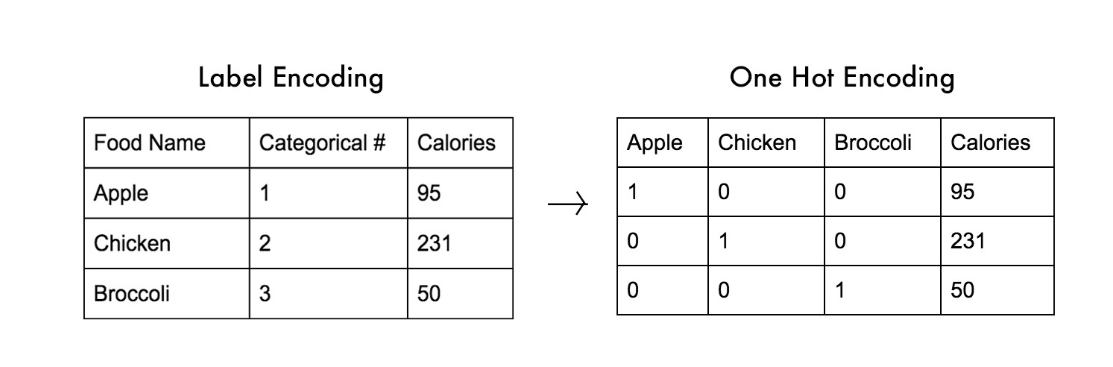

`两种编码方式的优缺点:`

- Label encoding
    - 优点：使用方便简单，不会创建新的变量，也可以自由定义数字。
    - 缺点：可解释性比较差，还会产生排序问题。因此，Label encoding编码其实并没有很多的应用场景。


- One-hot encoding
    - 优点：容易理解，解决了Label encoding的排序问题，在一定程度上也起到了扩充特征的作用。
    - 缺点：当类别的数量很多时，会创建过多变量，影响模型效果，而且导致运算速度过慢。


Define a one-hot encoding function:

  - 使用pandas.get_dummies(data, columns=None,dummy_na=False...)将字符型变量转化成哑变量(dummy variables)/指示列
    - 参数data代表想要转化的数据
    - 参数columns代表数据中想要进行转化的字符型变量
    - dummy_na=True代表对缺失值也添加一个指示列

In [54]:
s1 = ['a', 'b', np.nan]

In [55]:
pd.get_dummies(s1)


,a,b
0,1,0
1,0,1
2,0,0


In [56]:
pd.get_dummies(s1,dummy_na=True)

,a,b,NaN
0,1,0,0
1,0,1,0
2,0,0,1


In [57]:
def cate_convert(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [58]:
df2,cat_cols = cate_convert(df2, nan_as_category = True)

In [59]:
df2.head()

,loan_amnt,int_rate,installment,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,pub_rec_bankruptcies,target,term_36 months,term_60 months,term_nan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan
0,5000.0,0.1065,162.87,24000.0,1,27.65,0.0,1.0,NaN,3.0,0.0,13648.0,0.837,9.0,1.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,0.1527,59.83,30000.0,1,1.00,0.0,5.0,NaN,3.0,0.0,1687.0,0.094,4.0,1.0,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,0.1596,84.33,12252.0,0,8.72,0.0,2.0,NaN,2.0,0.0,2956.0,0.985,10.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000.0,0.1349,339.31,49200.0,1,20.00,0.0,1.0,35.0,10.0,0.0,5598.0,0.210,37.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3000.0,0.1269,67.79,80000.0,1,17.94,0.0,0.0,38.0,15.0,0.0,27783.0,0.539,38.0,1.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###### 2.8 Missing value imputation

In [60]:
missing=missing_values_table(df2)
missing

,Missing Values,% of Total Values
mths_since_last_delinq,25727,64.663449
revol_util,50,0.125672
pub_rec_bankruptcies,697,1.751873


In [61]:
df2['pub_rec_bankruptcies'].fillna(value=0,inplace=True)

Practice:
1. impute 0 for ['revol_util']'s missing values
1. impute 0 for ['mths_since_last_delinq']'s missing values 

In [62]:
df2['revol_util'].fillna(value=0,inplace=True)
df2['mths_since_last_delinq'].fillna(value=0,inplace=True)

In [63]:
# Check again:
missing=missing_values_table(df2)
missing

,Missing Values,% of Total Values


Backup the dataset:

In [64]:
final=df2.copy()
df2.to_csv('final_dataset_for_model.csv')

## Step Three: ML Modelling

###### 3.1 Check Correlations

In [65]:
correlations = final.corr()['target'].dropna().sort_values(ascending = False)

In [66]:
# Display correlations
print('Top Positive Correlations:\n', correlations.head(15))
print('\nTop Negative Correlations:\n', correlations.tail(15))

Top Positive Correlations:
 target                  1.000000
int_rate                0.197918
term_60 months          0.149151
revol_util              0.095925
grade_E                 0.088464
grade_D                 0.078370
grade_F                 0.077362
inq_last_6mths          0.071325
pub_rec                 0.050927
loan_amnt               0.050035
pub_rec_bankruptcies    0.047140
grade_G                 0.044960
dti                     0.041984
verification_status     0.038998
grade_C                 0.035708
Name: target, dtype: float64

Top Negative Correlations:
 addr_state_OH             -0.007789
addr_state_VA             -0.008817
open_acc                  -0.010199
addr_state_NY             -0.010491
addr_state_MA             -0.012153
addr_state_WY             -0.012336
addr_state_PA             -0.012936
addr_state_DC             -0.015234
addr_state_TX             -0.019222
total_acc                 -0.022640
home_ownership_MORTGAGE   -0.024870
annual_inc             

##### 3.2 Split into Test and Train datasets

In [67]:
x=final.drop(columns='target')
y=final['target']

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(29839, 84)
(29839,)
(9947, 84)
(9947,)


###### 3.3 Logistic regression model

1.Create the classifier(object)

In [69]:
logist= LogisticRegression()

2.Train the model on training data

In [70]:
logist.fit(x_train, y_train)

LogisticRegression()

3.Make the prediction:

Now that the model has been trained, we can use it to make predictions. 

We want to predict the probabilities of not paying a loan, so we use the model **predict_proba** method.

The first column is the probability of the target being 0 and the second column is the probability of the target being 1

In [71]:
log_reg_pred = logist.predict_proba(x_test)
y_pred_proba=log_reg_pred[:,1]
y_pred_proba

array([0.06488344, 0.21125751, 0.1988048 , ..., 0.23782679, 0.14403556,
       0.15653833])

Predict the label:

**.predict()** is for predicting class labels:

scikit-learn is using a threshold of P>0.5 for binary classifications

In [72]:
y_pred = logist.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Get the coefficient list:

In [73]:
coefficients = pd.concat([pd.DataFrame(list(x_train.columns)),pd.DataFrame(np.transpose(logist.coef_))], axis = 1)
coefficients

,0,0
0,loan_amnt,0.000092
1,int_rate,-0.000093
2,installment,-0.002933
3,annual_inc,-0.000015
4,verification_status,-0.000536
...,...,...
79,addr_state_WA,-0.000048
80,addr_state_WI,-0.000035
81,addr_state_WV,-0.000035
82,addr_state_WY,-0.000017


**Check key metrics**

An **ROC curve** is a plot of True Positive Rate vs False Positive Rate where False Positive Rate=FP/(TN+FP) =1-Specificity.

4.Show the ROC_CURVE to evaluate the model performance

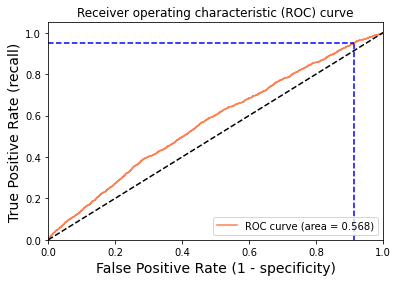

In [74]:
import numpy as np
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensibility > 0.95
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

**AUROC** (Area Under the Receiver Operating Characteristics)
The more the area enclosed by the ROC curve, the better it is. The area under the curve can lie between 0 and 1. The closer it is to 1, the better it is

###### 3.4 Random Forest

**Ensemble learning**, in general, is a model that makes predictions based on a number of different models. By combining individual models, the ensemble model tends to be more flexible (less bias) and less data-sensitive (less variance)
Two most popular ensemble methods are bagging and boosting.

**Bagging**: Training a bunch of individual models in a parallel way. Each model is trained by a random subset of the data => bootstrapping the data plus using the aggregate to make a decision is called bagging!

- **Random forest** is an ensemble model using bagging as the ensemble method and decision tree as the individual model.

**Boosting**: Training a bunch of individual models in a sequential way. Each individual model learns from mistakes made by the previous model

- **Gradient Boosting**: GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree. GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

Practice:

1.Create the classifier(object):

In [75]:
rf_model = RandomForestClassifier(
   n_estimators=200,
    max_depth=5)

2.Train the model on training data:

In [76]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200)

3.Make the prediction:

In [77]:
rf_model_pred = rf_model.predict_proba(x_test)
y_pred_proba=rf_model_pred[:,1]
y_pred_proba

array([0.11128416, 0.1187037 , 0.15967557, ..., 0.25030905, 0.07985659,
       0.09583597])

4.Show the ROC_CURVE to evaluate the model performance:

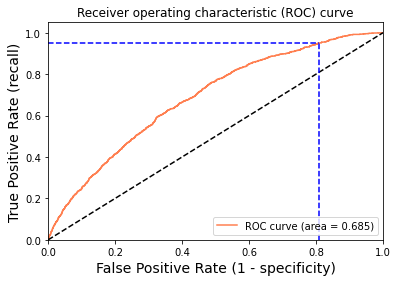

In [78]:
import numpy as np
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensibility > 0.95
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Get the feature importances for each feature using the following code:

In [79]:
rf_model.feature_importances_

array([1.91635737e-02, 2.12343646e-01, 2.16902578e-02, 4.94589742e-02,
       2.64325688e-03, 2.19205906e-02, 4.17983115e-03, 3.30686807e-02,
       9.77666370e-03, 1.62904406e-02, 1.52842649e-02, 1.51915393e-02,
       6.19486854e-02, 1.68153327e-02, 0.00000000e+00, 1.09535941e-02,
       1.07524151e-01, 1.02540373e-01, 0.00000000e+00, 1.07641687e-01,
       2.35780170e-02, 7.92267471e-03, 2.88023682e-02, 3.76968046e-02,
       2.50321858e-02, 5.03161288e-03, 0.00000000e+00, 3.47901039e-03,
       0.00000000e+00, 4.73669964e-04, 7.65006267e-04, 2.46480072e-03,
       0.00000000e+00, 6.61885735e-04, 6.51374711e-04, 1.99131626e-04,
       7.21685549e-04, 2.40574643e-03, 5.73242850e-04, 6.63830882e-04,
       6.93070536e-04, 4.34396397e-05, 2.30567942e-03, 8.59041016e-04,
       5.44892006e-04, 0.00000000e+00, 3.79893063e-05, 7.72089779e-04,
       0.00000000e+00, 6.05179741e-04, 1.04236420e-03, 5.15065298e-04,
       6.35637813e-04, 7.32713325e-04, 5.01309086e-06, 5.32539590e-04,
      

Associate these feature importances with the corresponding features:

In [80]:
feature_importance_df = pd.DataFrame(list(zip(rf_model.feature_importances_, list(x_train.columns))))
feature_importance_df.columns = ['feature.importance', 'feature']
feature_importance_df.sort_values(by='feature.importance', ascending=False).head(20) # only show top 20

,feature.importance,feature
1,0.212344,int_rate
19,0.107642,grade_A
16,0.107524,term_36 months
17,0.102540,term_60 months
12,0.061949,revol_util
3,0.049459,annual_inc
23,0.037697,grade_E
7,0.033069,inq_last_6mths
22,0.028802,grade_D
24,0.025032,grade_F
